In [1]:
import jax.numpy as jnp
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from liesel_sparse import band

In [2]:
%%capture
# Import my GP
%run ./GP.ipynb

In [3]:
#plt.style.use('bmh')
plt.style.use("seaborn-v0_8-muted")

In [4]:
# /textwidth 472.31595pt.
# \OT1/cmr/m/n/10.95=select font cmr10 at 10.95pt
# \textfont a (a): cmmi10 at 10.95pt
# \scriptfont a (a): cmmi8
# \textfont \alpha (α): cmmi10 at 10.95pt
# \textfont \cap (∩): cmsy10 at 10.95pt
# \textfont = (=): cmr10 at 10.95pt

def set_size(width_pt=472.31595, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to sit nicely in our document.

    Parameters
    ----------
    width_pt: float
            Document width in points
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    golden_ratio = (5 ** .5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return fig_width_in, fig_height_in


colors = ["white", "#005f9b", "#153268"]
nodes = [0.0, 0.8, 1.0]
unimap = matplotlib.colors.LinearSegmentedColormap.from_list("unimap", list(zip(nodes, colors)))
unimap_r = unimap.reversed()
try:
    matplotlib.colormaps.register(cmap=unimap)
    matplotlib.colormaps.register(cmap=unimap_r)
except ValueError:
    pass

plt.rcParams.update({
    "font.family": "serif",  # use serif/main font for text elements
    "font.serif": "Computer Modern Roman",
    "text.usetex": True,  # use inline math for ticks
    "text.latex.preamble": r"\usepackage{amsmath}",
    "pgf.rcfonts": False,  # don't setup fonts from rc parameters
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10.95,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    # Cmap
    "image.cmap": "unimap"
})

# Benchmarks

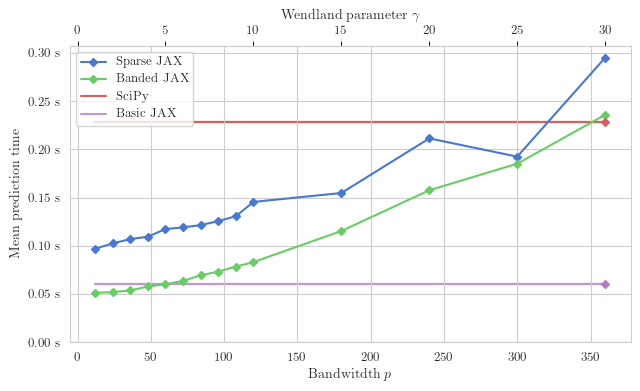

In [29]:
df = pd.read_csv('applications/res/MaunaLoa.py.csv', header=0)

df.wendland = pd.to_numeric(df.wendland)

df = df[(df.bw <=400)| (df.fun.eq('full')) | (df.fun.eq('jax'))]

fig, axs = plt.subplots(1, 1, figsize=set_size(fraction=1, subplots=(1, 1)))

for i, ax in enumerate(np.ravel(axs)):
    target = 'bw'

    df_ = df[df.fun.eq('sparse')]
    ax.plot(df_[target], df_.time, label='Sparse JAX', marker='D', markersize=4)
    df_ = df[df.fun.eq('band')]
    ax.plot(df_[target], df_.time, label='Banded JAX',  marker='D', markersize=4)

    ax.plot(df[target], np.vectorize(lambda _ : df[df.fun.eq('full')].time)(df[target]), zorder = -1, label = 'SciPy')
    ax.scatter(df.bw.max(), df[df.fun.eq('full')].time, zorder = 5, marker='D', s=4**2, c="C2")
    ax.plot(df[target], np.vectorize(lambda _ : df[df.fun.eq('jax')].time)(df[target]), alpha = .8, zorder = -1, label = 'Basic JAX')
    ax.scatter(df.bw.max(), df[df.fun.eq('jax')].time, zorder = 5, marker='D', s=4**2, c= "C3")

    secax = ax.secondary_xaxis('top', functions=(lambda x : x/12, lambda x : x * 12))
    secax.set_xlabel('Wendland parameter $\gamma$')

    ax.set_xlabel(rf"Bandwitdth $p$")
    ax.set_ylabel(rf"Mean prediction time")
    ax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%.2f s'))
    ax.set_ylim(bottom = 0)

    if i == 0:
        ax.legend(loc='upper left')

plt.tight_layout()
plt.show()
fig.savefig('maunaloabench.pdf', format='pdf', bbox_inches='tight')

In [121]:
df = pd.read_csv('applications/res/MaunaLoa.py.csv', header=0)
df = df.fillna(-1)
df.wendland = df.wendland.replace(np.inf, -1)
df.wendland = df.wendland.astype(int)
df.bw = df.bw.astype(int)

df = df.sort_values(['wendland', 'fun'])

df.time = df.time*1000

df.nse = df.nse/df.nse.max()*100

#df = df[(df.fun != 'sparse' ) | (df.wendland == -1)]

df = df[df['wendland'].isin([-1,1,2,3,4,5,8,10,20,30,70])]
df = df.drop(['tstd', 'relative', 'nmll'], axis = 1)

print(df.to_latex(index = False, float_format="%.3f").replace('-1', '$\infty$'))

\begin{tabular}{lrrrr}
\toprule
   fun &  wendland &    time &  bw &     nse \\
\midrule
  band &        $\infty$ & 732.347 & 778 & 100.000 \\
  full &        $\infty$ & 228.381 &  $\infty$ & 100.000 \\
   jax &        $\infty$ &  60.704 &  $\infty$ & 100.000 \\
sparse &        $\infty$ & 430.787 & 778 & 100.000 \\
  band &         1 &  51.432 &  12 &   2.947 \\
sparse &         1 &  96.970 &  12 &   2.947 \\
  band &         2 &  52.055 &  24 &   5.956 \\
sparse &         2 & 102.566 &  24 &   5.956 \\
  band &         3 &  53.790 &  36 &   8.919 \\
sparse &         3 & 107.060 &  36 &   8.919 \\
  band &         4 &  57.933 &  48 &  11.825 \\
sparse &         4 & 109.511 &  48 &  11.825 \\
  band &         5 &  60.089 &  60 &  14.706 \\
sparse &         5 & 117.468 &  60 &  14.706 \\
  band &         8 &  73.325 &  96 &  23.018 \\
sparse &         8 & 125.645 &  96 &  23.018 \\
  band &        10 &  83.168 & 120 &  28.335 \\
sparse &        10 & 145.555 & 120 &  28.335 \\
  band &   

/tmp/ipykernel_6365/2639676238.py:18: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index = False, float_format="%.3f").replace('-1', '$\infty$'))


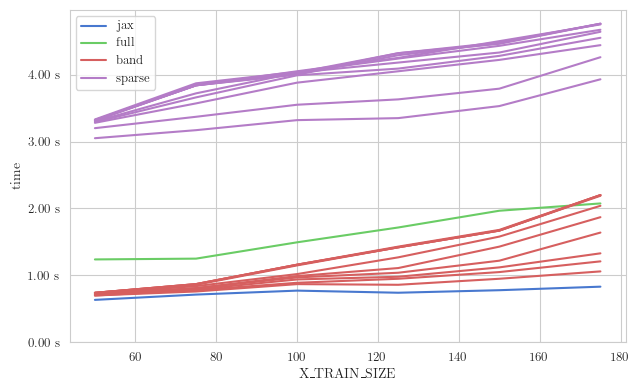

In [20]:
df = pd.read_csv('applications/res/Dendro.py.csv', header=0)

df.wendland = pd.to_numeric(df.wendland, errors = 'coerce')
df.wendland = df.wendland.fillna(-1)

#df = df[(df.bw <=400)| (df.fun.eq('full')) | (df.fun.eq('jax'))]

fig, axs = plt.subplots(1, 1, figsize=set_size(fraction=1, subplots=(1, 1)))

sns.lineplot(data = df, x = 'X_TRAIN_SIZE', y = 'time', hue = 'fun', units = 'wendland', estimator = None)
#
# for i, ax in enumerate(np.ravel(axs)):
#     target = 'bw'
#
#     df_ = df[df.fun.eq('sparse')]
#     ax.plot(df_[target], df_.time, alpha = .5, label='Sparse JAX')
#     df_ = df[df.fun.eq('band')]
#     ax.plot(df_[target], df_.time, label='Banded JAX')
#
#     ax.plot(df[target], np.vectorize(lambda _ : df[df.fun.eq('full')].time)(df[target]), alpha = .8, zorder = -1, label = 'SciPy')
#     ax.plot(df[target], np.vectorize(lambda _ : df[df.fun.eq('jax')].time)(df[target]), alpha = .8, zorder = -1, label = 'Basic JAX')
#
#     secax = ax.secondary_xaxis('top', functions=(lambda x : x/12, lambda x : x * 12))
#     secax.set_xlabel('Wendland parameter $\gamma$')
#
#     ax.set_xlabel(rf"Bandwitdth $p$")
#     ax.set_ylabel(rf"Mean prediction time")
plt.gca().yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%.2f s'))
#     ax.set_ylim(bottom = 0)
#
#     if i == 0:
plt.gca().legend(loc='upper left')
plt.gca().set_ylim(bottom = 0)
plt.tight_layout()
plt.show()
#fig.savefig('maunaloabench.pdf', format='pdf', bbox_inches='tight')

In [121]:
df = pd.read_csv('applications/res/MaunaLoa.py.csv', header=0)
df = df.fillna(-1)
df.wendland = df.wendland.replace(np.inf, -1)
df.wendland = df.wendland.astype(int)
df.bw = df.bw.astype(int)

df = df.sort_values(['wendland', 'fun'])

df.time = df.time*1000

df.nse = df.nse/df.nse.max()*100

#df = df[(df.fun != 'sparse' ) | (df.wendland == -1)]

df = df[df['wendland'].isin([-1,1,2,3,4,5,8,10,20,30,70])]
df = df.drop(['tstd', 'relative', 'nmll'], axis = 1)

print(df.to_latex(index = False, float_format="%.3f").replace('-1', '$\infty$'))

\begin{tabular}{lrrrr}
\toprule
   fun &  wendland &    time &  bw &     nse \\
\midrule
  band &        $\infty$ & 732.347 & 778 & 100.000 \\
  full &        $\infty$ & 228.381 &  $\infty$ & 100.000 \\
   jax &        $\infty$ &  60.704 &  $\infty$ & 100.000 \\
sparse &        $\infty$ & 430.787 & 778 & 100.000 \\
  band &         1 &  51.432 &  12 &   2.947 \\
sparse &         1 &  96.970 &  12 &   2.947 \\
  band &         2 &  52.055 &  24 &   5.956 \\
sparse &         2 & 102.566 &  24 &   5.956 \\
  band &         3 &  53.790 &  36 &   8.919 \\
sparse &         3 & 107.060 &  36 &   8.919 \\
  band &         4 &  57.933 &  48 &  11.825 \\
sparse &         4 & 109.511 &  48 &  11.825 \\
  band &         5 &  60.089 &  60 &  14.706 \\
sparse &         5 & 117.468 &  60 &  14.706 \\
  band &         8 &  73.325 &  96 &  23.018 \\
sparse &         8 & 125.645 &  96 &  23.018 \\
  band &        10 &  83.168 & 120 &  28.335 \\
sparse &        10 & 145.555 & 120 &  28.335 \\
  band &   

/tmp/ipykernel_6365/2639676238.py:18: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index = False, float_format="%.3f").replace('-1', '$\infty$'))


### Kernel Matrix

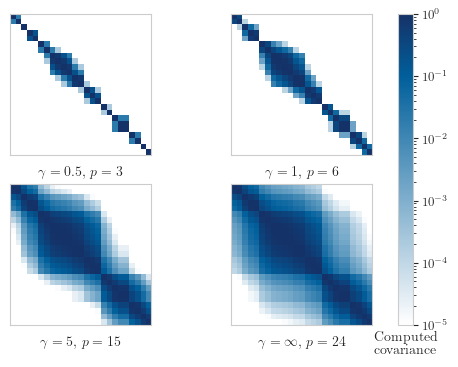

In [5]:
rng = np.random.RandomState(2)
toy_X = jnp.sort(rng.choice(jnp.linspace(0, 10, 100), 25))

fig, axs = plt.subplots(2, 2, figsize=set_size(fraction=1, subplots=(2, 2)))

for i, ax in enumerate(axs.flat):
    thetas = [0.5, 1, 5, float("inf")]
    k = lambda *args: MaternKernel32(1, 0.7, *args) * WendlandTapering(3, thetas[i], *args)
    K = cov_matrix(toy_X, toy_X, k)

    thetas[-1] = r"\infty"
    im = ax.matshow(K, norm=matplotlib.colors.LogNorm(vmin=1e-5, vmax=1))
    ax.set_xlabel(rf"$\gamma = {thetas[i]}$, $p = {band.bandwidth(K)}$")
    ax.get_xaxis().set_ticks([]);
    ax.get_yaxis().set_ticks([])

clb = fig.colorbar(im, ax=axs.ravel().tolist())
clb.ax.set_xlabel("Computed\n covariance")
plt.show()
fig.savefig('wendlands.pdf', format='pdf', bbox_inches='tight')

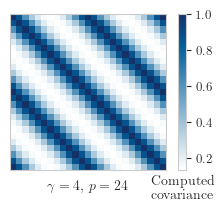

In [6]:
rng = np.random.RandomState(2)
#toy_X = jnp.sort(rng.choice(jnp.linspace(0, 10, 100), 25))
toy_X = jnp.linspace(0, 10, 25)

fig, ax = plt.subplots(1, 1, figsize=set_size(fraction=.5, subplots=(1, 1)))

k = lambda *args: ExpSineSquaredKernel(1, 1, 5, *args)  # * WendlandTapering(3, 3, *args)
K = cov_matrix(toy_X, toy_X, k)

im = ax.matshow(K)  #, norm=matplotlib.colors.LogNorm(vmax=1))
ax.set_xlabel(rf"$\gamma = 4$, $p = {band.bandwidth(K)}$")
ax.get_xaxis().set_ticks([]);
ax.get_yaxis().set_ticks([])

clb = fig.colorbar(im, ax=ax)
clb.ax.set_xlabel("Computed\n covariance")
plt.show()
fig.savefig('kernel.pdf', format='pdf', bbox_inches='tight')

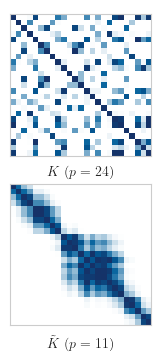

In [7]:
rng = np.random.RandomState(2)
toy_X = rng.choice(jnp.linspace(0, 10, 100), 25)

fig, axs = plt.subplots(2, 1, figsize=set_size(fraction=.5, subplots=(2, 1)))

for i, ax in enumerate(axs.flat):
    k = lambda *args: MaternKernel32(1, 5, *args) * WendlandTapering(3, 3, *args)
    K = cov_matrix(toy_X, toy_X, k)
    if i:
        K, _ = band.permute(K)

    im = ax.matshow(K)
    ax.set_xlabel(rf"$K\ (p = {band.bandwidth(K)})$" if not i else
                  r"$\tilde{K}\ " + rf"(p = {band.bandwidth(K)})$")
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

plt.show()
fig.savefig('cuthill.pdf', format='pdf', bbox_inches='tight')

## Kernel graph

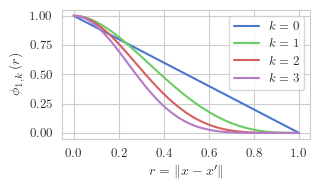

In [93]:
rng = np.random.RandomState(2)
r = jnp.linspace(0, 1, 100)

fig, axs = plt.subplots(1, 1, figsize=set_size(fraction=.5, subplots=(1, 1)))
#plt.subplots_adjust(bottom=-0.1)

for k in [0, 1, 2, 3]:
    y = jax.vmap(lambda y_: WendlandTapering(k, 1, y_, 0))(r)
    im = axs.plot(r, y, label=f"$k = {k}$")

plt.gca().set_xlabel(r"$r = \lVert x - x' \rVert$")
plt.gca().set_ylabel(r"$\phi_{1, k}\left(r\right)$")
axs.legend()

plt.tight_layout()
plt.show()
fig.savefig('wendlandsr.pdf', format='pdf', bbox_inches='tight')

## Draw Functions (prior)

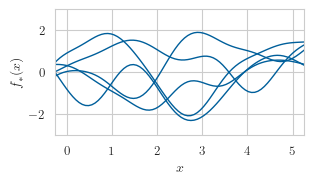

In [9]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import *

kernel_ = RBF(length_scale=0.7)
gpr_model = GaussianProcessRegressor(kernel=kernel_)
n_samples = 5

x = np.linspace(-1, 6, 100)
X = x.reshape(-1, 1)

y_samples = gpr_model.sample_y(X, n_samples, random_state=2)

fig, ax = plt.subplots(1, 1, figsize=set_size(fraction=.5, subplots=(1, 1)))

for idx, single_prior in enumerate(y_samples.T):
    ax.plot(x, single_prior, alpha=1, lw=1, c=unimap(0.8))

ax.set_xlabel("$x$")
ax.set_ylabel("$f_*(x)$")
ax.set_xlim([-0.25, 5.25])
ax.set_ylim([-3, 3])
plt.tight_layout()
plt.show()
fig.savefig('drawprior.pdf', format='pdf', bbox_inches='tight')

## Draw Functions (posterior, no noise)

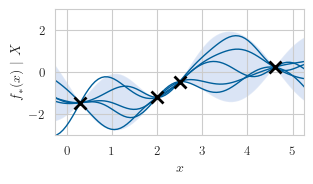

In [10]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import *

kernel_ = RBF(length_scale=0.7)
gpr_model = GaussianProcessRegressor(kernel=kernel_, optimizer=None, alpha=0)
n = 4
x_points = np.array([0.3, 2, 2.5, 4.6]).reshape(-1, 1)
y_points = np.random.rand(n) * 3 - 3 / 2
gpr_model.fit(x_points, y_points)

n_samples = 5

x = np.linspace(-1, 6, 100)
X = x.reshape(-1, 1)

y_samples = gpr_model.sample_y(X, n_samples, random_state=5)

fig, ax = plt.subplots(1, 1, figsize=set_size(fraction=.5, subplots=(1, 1)))
plt.plot(x_points, y_points, marker="x", lw=0, mew=2, ms=8, alpha=1, zorder=5, c='k')

for idx, single_prior in enumerate(y_samples.T):
    ax.plot(x, single_prior, alpha=1, lw=1, c=matplotlib.cm.get_cmap("unimap")(0.8))

pred_mean, pred_var = gpr_model.predict(X, return_std=True)
ax.fill_between(x, pred_mean - 1.96 * pred_var, pred_mean + 1.96 * pred_var, alpha=0.2, zorder=-1)

ax.set_xlabel("$x$")
ax.set_ylabel("$f_*(x)\ |\ X$")
ax.set_xlim([-0.25, 5.25])
ax.set_ylim([-3, 3])
plt.tight_layout()
plt.show()
fig.savefig('drawposterior.pdf', format='pdf', bbox_inches='tight')

/tmp/ipykernel_161977/905097137.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ax.plot(x, pred_mean, alpha=1, lw=1, c=matplotlib.cm.get_cmap("unimap")(1.0))
/tmp/ipykernel_161977/905097137.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color=matplotlib.cm.get_cmap("unimap")(.5))
/tmp/ipykernel_161977/905097137.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ax.plot(x, pred_mean, alpha=1, lw=1, c=matplotlib.cm.get_cmap("unimap")(1.0))
/tmp/ipykernel_161977/9050

TypeError: 'Axes' object is not subscriptable

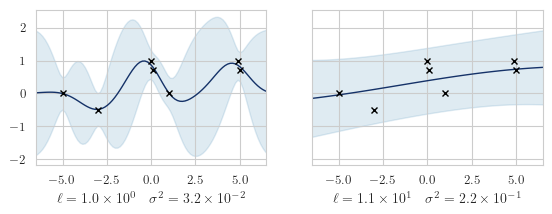

In [86]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import *
from num2tex import num2tex

fig, axs = plt.subplots(1, 2, figsize=set_size(fraction=1, subplots=(1, 2)), sharey="all")

X_train = np.array([-5, -3, 0, .1, 1, 4.9, 5]).reshape(-1, 1)
x = np.linspace(-7, 7, 100)
y_train = np.array([0, -.5, 1, .7, 0, 1, .7])

opts = list()

for i, ax in enumerate(axs.flat):
    if i == 0:
        kernel = RBF(1) + WhiteKernel(1)
    else:
        kernel = RBF(10) + WhiteKernel(1e-1)

    gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=0, alpha=0)
    gpr.fit(X_train, y_train)
    pred_mean, pred_var = gpr.predict(x.reshape(-1, 1), return_std=True)
    ax.plot(x, pred_mean, alpha=1, lw=1, c=matplotlib.cm.get_cmap("unimap")(1.0))
    ax.fill_between(x, pred_mean - 1.96 * pred_var, pred_mean + 1.96 * pred_var, alpha=0.2, zorder=-1,
                    color=matplotlib.cm.get_cmap("unimap")(.5))
    ax.plot(X_train, y_train, marker="x", lw=0, mew=1, ms=4, alpha=1, zorder=5, c='k')
    ax.set_xlabel("$\ell = {:.1e}\quad".format(num2tex(np.exp(gpr.kernel_.theta[0]))) +
                  "\sigma^2 = {:.1e}$".format(num2tex(np.exp(gpr.kernel_.theta[1]))))
    ax.set_xlim([-6.5, 6.5])

    opts.append(np.exp(gpr.kernel_.theta))

ax[0].set_ylabel("f(x)")
plt.tight_layout()
plt.show()
fig.savefig('optima.pdf', format='pdf', bbox_inches='tight', dpi=300)

## Contour

5.734802786716455 591.4438104119218


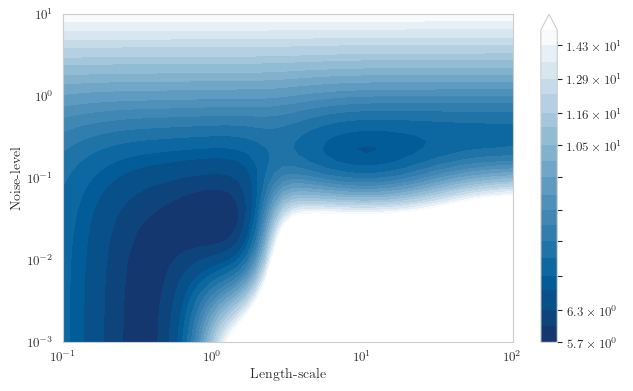

In [33]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import *
from matplotlib.colors import LogNorm

fig, ax = plt.subplots(1, 1, figsize=set_size(fraction=1, subplots=(1, 1)))

X_train = np.array([-5, -3, 0, .1, 1, 4.9, 5]).reshape(-1, 1)
y_train = np.array([0, -.5, 1, .7, 0, 1, .7])

kernel = RBF() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel, optimizer=None)
gpr.fit(X_train, y_train)

length_scale = np.logspace(-1, 2, num=50)
noise_level = np.logspace(-3, 1, num=50)
length_scale_grid, noise_level_grid = np.meshgrid(length_scale, noise_level)

log_marginal_likelihood = [
    gpr.log_marginal_likelihood(theta=np.log([scale, noise]))
    for scale, noise in zip(length_scale_grid.ravel(), noise_level_grid.ravel())
]
log_marginal_likelihood = np.reshape(
    log_marginal_likelihood, newshape=noise_level_grid.shape
)

vmin, vmax = (-log_marginal_likelihood).min(), (-log_marginal_likelihood).max()
print(vmin, vmax)
vmax = 15
level = np.around(np.logspace(np.log10(vmin), np.log10(vmax), num=20), decimals=1)
im = ax.contourf(
    length_scale_grid, noise_level_grid, -log_marginal_likelihood,
    levels=level, norm=LogNorm(), cmap="unimap_r", extend="max", antialiased=False
)

plt.colorbar(im, extend='max')
plt.xscale("log");
plt.yscale("log")
plt.xlabel("Length-scale");
plt.ylabel("Noise-level")
plt.tight_layout()
plt.show()
fig.savefig('contour.pdf', format='pdf', bbox_inches='tight', dpi=300)

## Contour (L-BFGS-B)

True


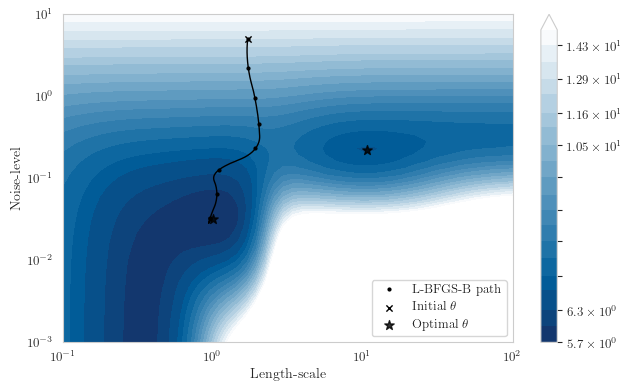

In [91]:

from sklearn.gaussian_process.kernels import *
from matplotlib.colors import LogNorm
from scipy import optimize

from scipy.interpolate import BSpline, make_interp_spline

fig, ax = plt.subplots(1, 1, figsize=set_size(fraction=1, subplots=(1, 1)))


def obj_func(theta):
    lml, grad = gpr.log_marginal_likelihood(np.log(theta), eval_gradient=True, clone_kernel=False)
    return -lml, -grad


x0 = [1.7, 5]
path = [x0]

res = optimize.minimize(fun=obj_func, x0=x0, bounds=[(1e-1, 1e2), (1e-3, 1e1)], method="L-BFGS-B", jac=True,
                        callback=lambda xk: path.append(np.copy(xk)), tol=1e-3)

# ax.quiver(path[0,:-1], path[1,:-1], path[0,1:]-path[0,:-1], path[1,1:]-path[1,:-1],
#           scale_units='xy', angles='xy', scale=1.2, color='k', zorder=10, alpha=.6,
#           width = .003)

ax.plot(*np.array(path).T, zorder=11, c="k", marker="o", markersize=2, linewidth=0, label="L-BFGS-B path")

x = range(len(path))
y = np.array(path)
b = make_interp_spline(x, y, k=2)
print(np.allclose(b(x), y))

ax.plot(*np.array(b(np.linspace(0, max(x), 200))).T, zorder=10, alpha=1, c="k", linewidth=1,)
ax.plot(*np.array(b(np.linspace(0, max(x), 200))).T, zorder=9, alpha=1, c="w", linewidth=0,)
ax.scatter(*x0, marker="x", s=20, lw=1, c="k", label=r"Initial $\theta$", zorder=20)
ax.scatter(*zip(opts[0], opts[1]), marker="*", s=50, c="k", alpha=.8, label=r"Optimal $\theta$", zorder=20)

im = ax.contourf(
    length_scale_grid, noise_level_grid, -log_marginal_likelihood,
    levels=level, norm=LogNorm(), cmap="unimap_r", extend="max"
)

ax.legend(loc='lower right')
plt.colorbar(im, extend='max')
plt.xscale("log");plt.yscale("log")
plt.xlabel("Length-scale");plt.ylabel("Noise-level")
plt.tight_layout()
plt.show()
fig.savefig('contourlbfgsb.pdf', format='pdf', bbox_inches='tight', dpi=300)

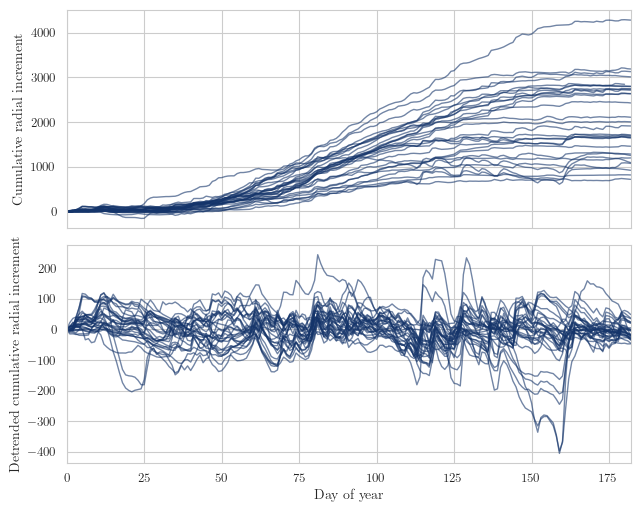

In [72]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=set_size(fraction=1, subplots=(1.3, 1)), sharex=True)

rng = np.random.default_rng(3)
df_ = pd.read_feather('./data/17766_12.feather')
samp_ = rng.choice(df_.dendroNr.unique(), size=30, replace=False,)
df_ = df_[df_.dendroNr.isin(samp_)]

sns.lineplot(x = df_.DOY, y = df_.growth, units = df_.dendroNr, ax = ax1, estimator = None, lw = 1, alpha = .6, color = unimap(.99))
ax1.set_xlabel("Day of year");ax1.set_ylabel("Cumulative radial increment")
ax1.autoscale(axis = 'x', tight=True)

sns.lineplot(x = df_.DOY, y = df_.deltagrowth, units = df_.dendroNr, ax = ax2, estimator = None, lw = 1, alpha = .6, color = unimap(.99))
ax2.set_xlabel("Day of year");ax2.set_ylabel("Detrended cumulative radial increment")
ax2.autoscale(axis = 'x', tight=True)

plt.tight_layout()
plt.show()
fig.savefig('weibulltrees.pdf', format='pdf', bbox_inches='tight', dpi=300)

Ash (1630.0137227376301, 65.99420571071465, 1.6367807785669963)
Beech (2122.9595300886367, 97.75040674628902, 3.181185520357556)
Sycamore (1719.1334882463727, 98.70076393824007, 3.093429071562631)


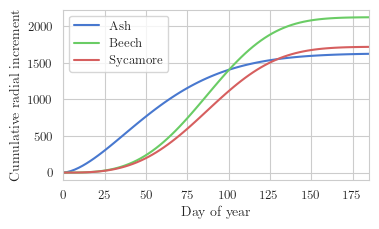

In [93]:
fig, ax = plt.subplots(1, 1, figsize=set_size(fraction=.6, subplots=(1, 1)))

df_ = pd.read_csv('./data/17766_Wparams.csv').drop('Unnamed: 0', axis=1).set_index('index')

def weibull_F(x, lambda_, k_):
    return 1 - np.exp(-(lambda_ * x) ** k_)

for label_, (p1, p2, p3) in df_.groupby('species').agg('mean').iterrows():
    print(label_, (p1, 1/p2, p3))
    plt.plot(np.linspace(0,185,80), p1 * weibull_F(np.linspace(0,185,80), p2, p3), label = label_)

ax.set_xlabel("Day of year");ax.set_ylabel("Cumulative radial increment")
ax.autoscale(axis = 'x', tight=True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('weibull.pdf', format='pdf', bbox_inches='tight', dpi=300)

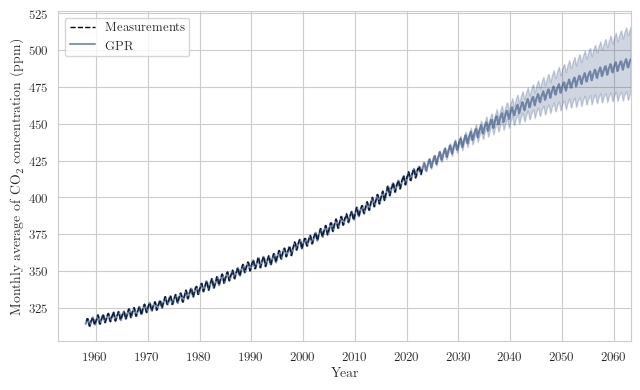

In [152]:
fig, ax = plt.subplots(1, 1, figsize=set_size(fraction=1, subplots=(1, 1)))

from sklearn.gaussian_process.kernels import *
from sklearn.gaussian_process import GaussianProcessRegressor
import datetime

df_ = pd.read_csv(r"data/co2_mm_mlo.csv", skiprows=56)
X = df_["decimal date"].to_numpy().reshape(-1, 1)
y = df_.average.to_numpy()

kernel_ = 112**2 * Matern(length_scale=115, nu = 5/2) +\
          2.58**2 * Matern(length_scale=199, nu = 5/2) * ExpSineSquared(length_scale=1.36, periodicity=1, periodicity_bounds="fixed") +\
          0.575**2 * RationalQuadratic(alpha=0.672, length_scale=1.05) +\
          0.208**2 * Matern(length_scale=0.128, nu = 5/2) + WhiteKernel(noise_level=0.0382)

gpr = GaussianProcessRegressor(kernel=kernel_, optimizer=None)
y_mean = y.mean()
gpr.fit(X, y - y_mean)

today = datetime.datetime.now()
X_test = np.linspace(start=1958, stop=today.year + 40 + today.month / 12, num=700).reshape(-1, 1)

mean_y_pred, std_y_pred = gpr.predict(X_test, return_std=True)
mean_y_pred += y_mean
plt.plot(X, y, color="black", linestyle="dashed", label="Measurements", lw = 1)
plt.plot(X_test, mean_y_pred, color=unimap(.99), alpha=0.5, label="GPR")
plt.fill_between(
    X_test.ravel(),
    mean_y_pred - std_y_pred,
    mean_y_pred + std_y_pred,
    alpha=0.2,
    color=unimap(0.99)
)
ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(11+1))
ax.set_xlabel("Year");ax.set_ylabel("Monthly average of CO$_2$ concentration (ppm)")

plt.legend(loc='upper left')
plt.xlim(right = max(X_test))
plt.tight_layout()
plt.show()
fig.savefig('maunaloa.pdf', format='pdf', bbox_inches='tight', dpi=300)

NMLL: 607.0064983129168


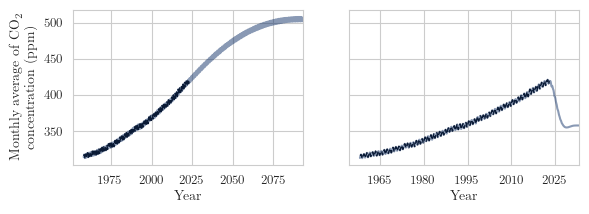

In [182]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=set_size(fraction=1, subplots=(1, 2)), sharey=True)

from sklearn.gaussian_process.kernels import *
from sklearn.gaussian_process import GaussianProcessRegressor
import datetime

df_ = pd.read_csv(r"data/co2_mm_mlo.csv", skiprows=56)
X = df_["decimal date"].to_numpy().reshape(-1, 1)
y = df_.average.to_numpy()
y_mean = y.mean()
today = datetime.datetime.now()
X_test = np.linspace(start=1958, stop=today.year + 70 + today.month / 12, num=1500).reshape(-1, 1)

# --------------
kernel_ = (
    112**2 * Matern(length_scale=115, nu=5 / 2)
    + 2.58**2
    * Matern(length_scale=199, nu=5 / 2)
    * ExpSineSquared(length_scale=1.36, periodicity=1, periodicity_bounds="fixed")
    + 0.575**2 * RationalQuadratic(alpha=0.672, length_scale=1.05)
    + 0.208**2 * Matern(length_scale=0.128, nu=5 / 2)
    + WhiteKernel(noise_level=0.0382)
)

gpr = GaussianProcessRegressor(kernel=kernel_, optimizer=None)

gpr.fit(X, y - y_mean)
mean_y_pred = gpr.predict(X_test, return_std=False)
mean_y_pred += y_mean
ax1.plot(X, y, color="black", linestyle="dashed", label="Measurements", lw=1)
ax1.plot(X_test, mean_y_pred, color=unimap(0.99), alpha=0.5, label="GPR")
ax1.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(5 + 1))
ax1.set_xlabel("Year")
ax1.set_ylabel("Monthly average of CO$_2$\n concentration (ppm)")

# ax1.legend(loc='best')
ax1.set_xlim(right=max(X_test))


# -------------
X_test = np.linspace(start=1958, stop=today.year + 10 + today.month / 12, num=1500).reshape(-1, 1)
def kernel_(x_, y_):
    return (
        MaternKernel52(112**2, 115, x_, y_)
        + MaternKernel52(2.58**2, 199, x_, y_) * ExpSineSquaredKernel(1, 1.36, 1, x_, y_)
        + RationalQuadraticKernel(0.575**2, 1.05, 0.672, x_, y_)
        + MaternKernel52(0.208**2, 0.128, x_, y_)
    ) * WendlandTapering(3, 10, x_, y_)


gpr = GPR(X, y - y_mean, kernel_, jnp.empty(0), eps=0.0382)
mean_y_pred = gpr.predict(X_test, return_std=False)
mean_y_pred += y_mean
ax2.plot(X, y, color="black", linestyle="dashed", label="Measurements", lw=1)
ax2.plot(X_test, mean_y_pred, color=unimap(0.99), alpha=0.5, label="GPR")
ax2.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(5 + 1))
ax2.set_xlabel("Year")

# ax1.legend(loc='best')
ax2.set_xlim(right=max(X_test))
# -------------
#plt.tight_layout()
plt.show()
#fig.savefig('maunaloafar.pdf', format='pdf', bbox_inches='tight', dpi=300)